In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [55]:
tokens = tokenizer.encode('This is Not Bad, But I Hate it', return_tensors='pt')

In [ ]:
tokens

tensor([[  101, 10372, 10127, 10497, 12428,   117, 10502,   151, 39487, 10197,
           102]])

In [ ]:
tokenizer.decode(tokens[0])

'[CLS] this is not bad, but i hate it [SEP]'

In [ ]:
result = model(tokens)

In [ ]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[-0.7933, -0.3915,  0.5733,  0.4336,  0.0813]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
torch.argmax(result.logits)

tensor(2)

In [ ]:
result.logits

tensor([[-0.7933, -0.3915,  0.5733,  0.4336,  0.0813]],
       grad_fn=<AddmmBackward0>)

In [ ]:
int(torch.argmax(result.logits))+1

3

In [39]:
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [40]:
reviews

["Very cute coffee shop and restaurant. They have a lovely outdoor seating area and several tables inside.  It was fairly busy on a Tuesday morning but we were to grab the last open table. The server was so enjoyable, she chatted and joked with us and provided fast service with our ordering, drinks and meals. The food was very good. We ordered a wide variety and every meal was good to delicious. The sweet potato fries on the Chicken Burger plate were absolutely delicious, some of the best I've ever had. I definitely enjoyed this cafe, the outdoor seating, the service and the food!!",
 "Six of us met here for breakfast before our walk to Manly. We were enjoying visiting with each other so much that I apologize for not taking any photos. We all enjoyed our food, as well as our coffee and tea drinks.We were greeted immediately by a friendly server asking if we would like to sit inside or out. We said we would like inside, but weren't exactly sure how many were joining us yet- at least 4. 

In [41]:
import numpy as np
import pandas as pd

In [43]:
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [58]:
def clean_review(review):
    review = re.sub(r'[^\w\s]', '', review)
    review = review.lower()
    return review

df['clean_review'] = df['review'].apply(clean_review)

In [59]:
df['review'].iloc[0]

"Very cute coffee shop and restaurant. They have a lovely outdoor seating area and several tables inside.  It was fairly busy on a Tuesday morning but we were to grab the last open table. The server was so enjoyable, she chatted and joked with us and provided fast service with our ordering, drinks and meals. The food was very good. We ordered a wide variety and every meal was good to delicious. The sweet potato fries on the Chicken Burger plate were absolutely delicious, some of the best I've ever had. I definitely enjoyed this cafe, the outdoor seating, the service and the food!!"

In [60]:
def batch_sentiment_scores(reviews):
    inputs = tokenizer(reviews, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        results = model(**inputs)
    return torch.argmax(results.logits, dim=-1) + 1

df['sentiment'] = batch_sentiment_scores(df['clean_review'].tolist())


In [62]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt', max_length=512, truncation=True)
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1

In [63]:
sentiment_score(df['review'].iloc[1])

4

In [76]:
def sentiment_with_confidence(review):
    tokens = tokenizer.encode(review, return_tensors='pt', max_length=512, truncation=True)
    result = model(tokens)
    logits = result.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs)
    confidence = probs[0][predicted_class].item()
    return predicted_class.item() + 1, confidence

In [65]:
df[['sentiment', 'confidence']] = df['clean_review'].apply(
    lambda x: pd.Series(sentiment_with_confidence(x[:512]))
)

In [66]:
df

,review,sentiment,clean_review,confidence
0,Very cute coffee shop and restaurant. They hav...,5.0,very cute coffee shop and restaurant they have...,0.500283
1,Six of us met here for breakfast before our wa...,4.0,six of us met here for breakfast before our wa...,0.264830
2,We came for brunch and they ran out of seven s...,2.0,we came for brunch and they ran out of seven s...,0.462359
3,The food was delicious. The ricotta pancakes w...,4.0,the food was delicious the ricotta pancakes we...,0.459188
4,Great place with delicious food and friendly s...,5.0,great place with delicious food and friendly s...,0.596721
5,Great food amazing coffee and tea. Short walk ...,5.0,great food amazing coffee and tea short walk f...,0.775823
6,We came for brunch twice in our week-long visi...,4.0,we came for brunch twice in our weeklong visit...,0.443060
7,"Great service, lovely location, and really ama...",5.0,great service lovely location and really amazi...,0.888535
8,Ricotta hot cakes! These were so yummy. I ate ...,5.0,ricotta hot cakes these were so yummy i ate th...,0.324339
9,It was ok. Had coffee with my friends. I'm new...,3.0,it was ok had coffee with my friends im new in...,0.773133


In [67]:
df['review'].iloc[5]

'Great food amazing coffee and tea. Short walk from the harbor. Staff was very friendly'

In [68]:
df.to_csv('sentiment_reviews.csv', index=False)

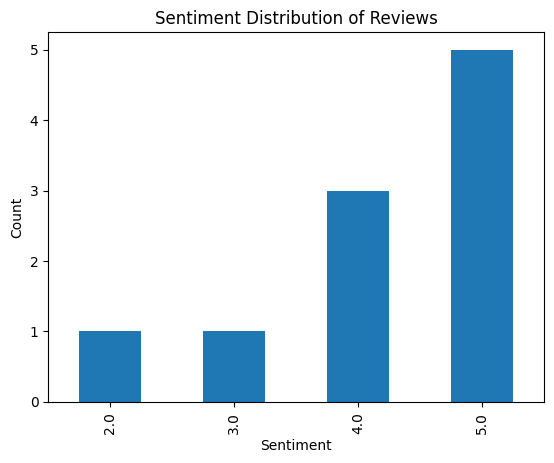

In [69]:
import matplotlib.pyplot as plt
df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Reviews')
plt.show()


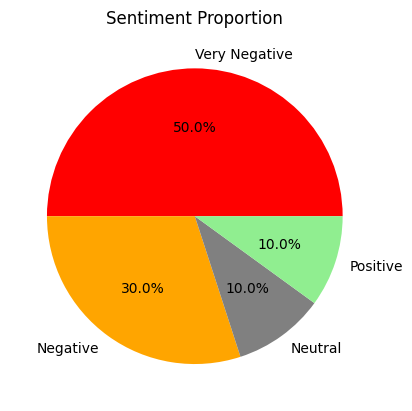

In [70]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'], colors=['red', 'orange', 'gray', 'lightgreen', 'green'])
plt.title('Sentiment Proportion')
plt.ylabel('')
plt.show()

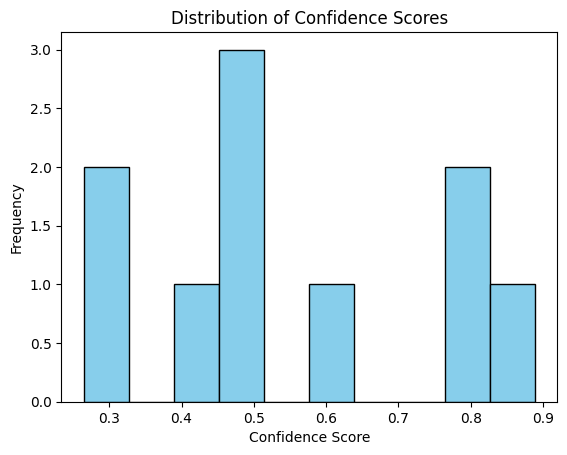

In [71]:
# Histogram of confidence scores
plt.hist(df['confidence'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores')
plt.show()

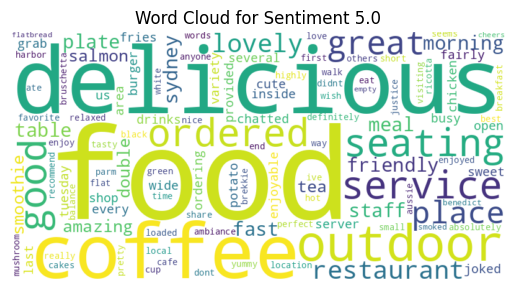

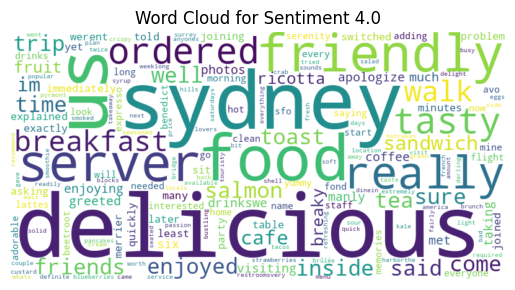

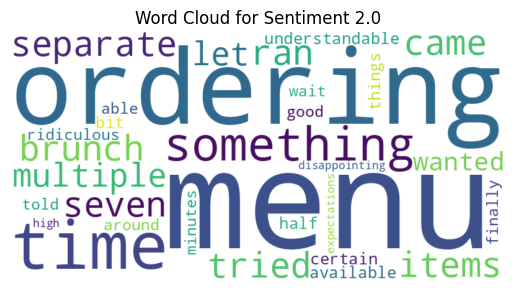

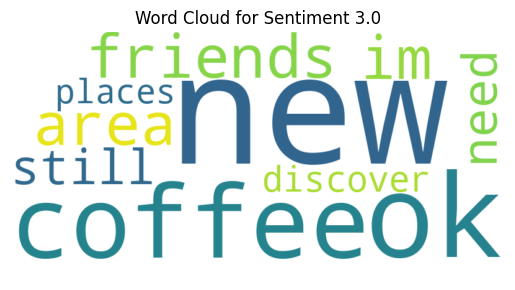

In [72]:
from wordcloud import WordCloud


for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Sentiment {sentiment}')
    plt.show()

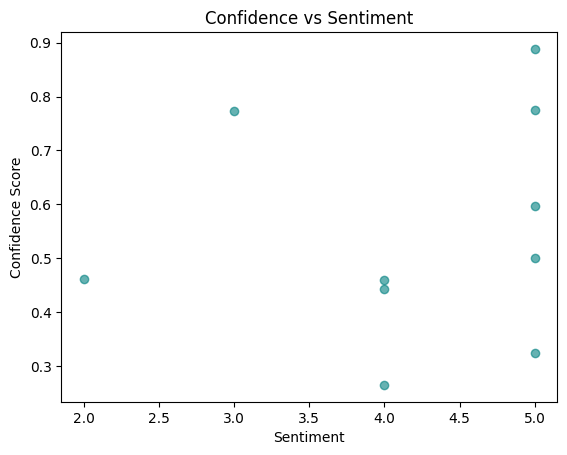

In [73]:
plt.scatter(df['sentiment'], df['confidence'], alpha=0.6, color='teal')
plt.xlabel('Sentiment')
plt.ylabel('Confidence Score')
plt.title('Confidence vs Sentiment')
plt.show()